In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
df = pd.read_csv('customer_aggregated_data.csv')
df.head()

,CustomerID,total_spent,total_items,num_transactions,num_unique_products,last_purchase,first_purchase,Country,avg_order_value,Country_encoded
0,12346.0,77183.60,74215,1,1,2011-01-18 10:01:00,2011-01-18 10:01:00,United Kingdom,77183.600000,35
1,12347.0,4310.00,2458,7,103,2011-12-07 15:52:00,2010-12-07 14:57:00,Iceland,615.714286,16
2,12348.0,1797.24,2341,4,22,2011-09-25 13:13:00,2010-12-16 19:09:00,Finland,449.310000,12
3,12349.0,1757.55,631,1,73,2011-11-21 09:51:00,2011-11-21 09:51:00,Italy,1757.550000,18
4,12350.0,334.40,197,1,17,2011-02-02 16:01:00,2011-02-02 16:01:00,Norway,334.400000,24


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           4338 non-null   float64
 1   total_spent          4338 non-null   float64
 2   total_items          4338 non-null   int64  
 3   num_transactions     4338 non-null   int64  
 4   num_unique_products  4338 non-null   int64  
 5   last_purchase        4338 non-null   object 
 6   first_purchase       4338 non-null   object 
 7   Country              4338 non-null   object 
 8   avg_order_value      4338 non-null   float64
 9   Country_encoded      4338 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 339.0+ KB


In [4]:
df['last_purchase'] = pd.to_datetime(df['last_purchase'])
df['first_purchase'] = pd.to_datetime(df['first_purchase'])

In [5]:
df['customer_lifetime_days'] = (df['last_purchase'] - df['first_purchase']).dt.days
df['avg_items_per_transaction'] = df['total_items'] / df['num_transactions']

In [6]:
df['days_since_first_purchase'] = (df['last_purchase'] - df['first_purchase']).dt.days
df['days_since_last_purchase'] = (pd.Timestamp('today') - df['last_purchase']).dt.days

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
le = LabelEncoder()
df['Country_encoded'] = le.fit_transform(df['Country'])

In [9]:
df.drop(columns=['CustomerID','last_purchase','first_purchase','Country'], inplace=True)

In [10]:
df.sample(4)

,total_spent,total_items,num_transactions,num_unique_products,avg_order_value,Country_encoded,customer_lifetime_days,avg_items_per_transaction,days_since_first_purchase,days_since_last_purchase
78,172.06,182,1,12,172.060,30,0,182.0,0,5118
3697,771.85,105,2,13,385.925,35,63,52.5,63,5300
3780,723.21,519,3,38,241.070,35,169,173.0,169,5145
2482,2211.21,1023,5,45,442.242,35,254,204.6,254,5151


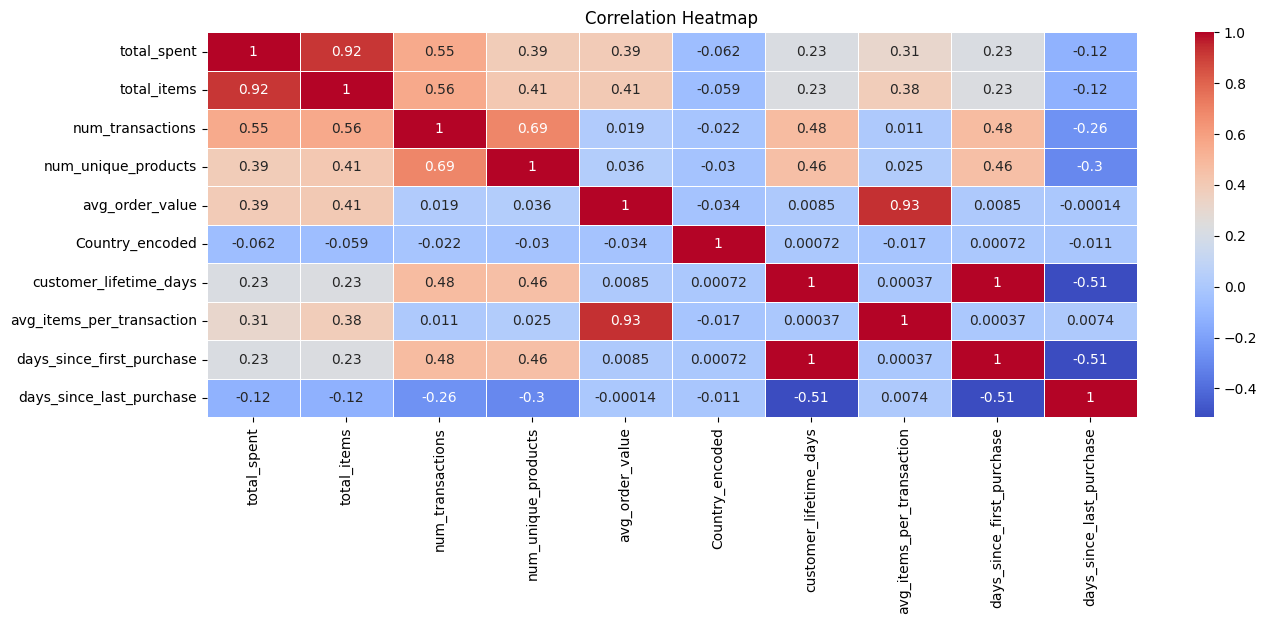

In [11]:
numeric_cols = [
    "total_spent",
    "total_items",
    "num_transactions",
    "num_unique_products",
    "avg_order_value",
    "Country_encoded",
    "customer_lifetime_days",
    "avg_items_per_transaction",
    "days_since_first_purchase",
    "days_since_last_purchase"
]

plt.figure(figsize=(15, 5))
sns.heatmap(df[numeric_cols].corr(), annot=True, linewidths=0.5, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [12]:
X = df.drop(columns=['total_spent'])
y = df['total_spent']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

In [15]:
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [16]:
y_pred = model.predict(X_test)

In [17]:
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)

MAE : 347.9983621642292
RMSE: 2629.689724010801
R2  : 0.9324167192380249


In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
param_grid = {
    # Tree structure
    'max_depth': [3, 8],
    'min_child_weight': [1, 3],
    
    # Learning process
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 300],
    
    # Subsampling
    'subsample': [0.8],
    'colsample_bytree': [0.7, 1.0],
    
    # Regularization
    'reg_lambda': [1],
    'reg_alpha': [0, 1],
    'gamma': [0],
    
    # Tree method
    'tree_method': ['hist']
}

In [20]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)


In [21]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7, 1.0], 'gamma': [0], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 8], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [22]:
print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'hist'}
Best Score: -15265623.669211574


In [23]:
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

MAE : 347.9983621642292
RMSE: 2629.689724010801
R²  : 0.9324167192380249


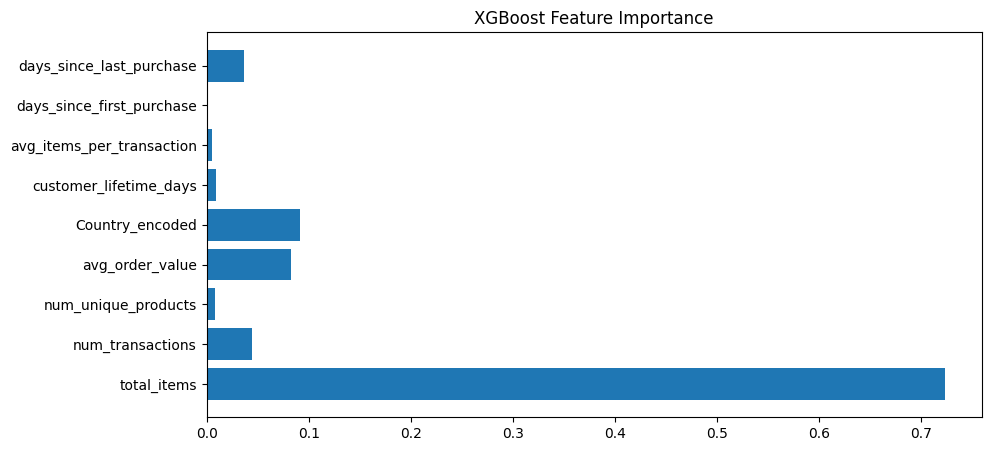

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.barh(X.columns, model.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.show()

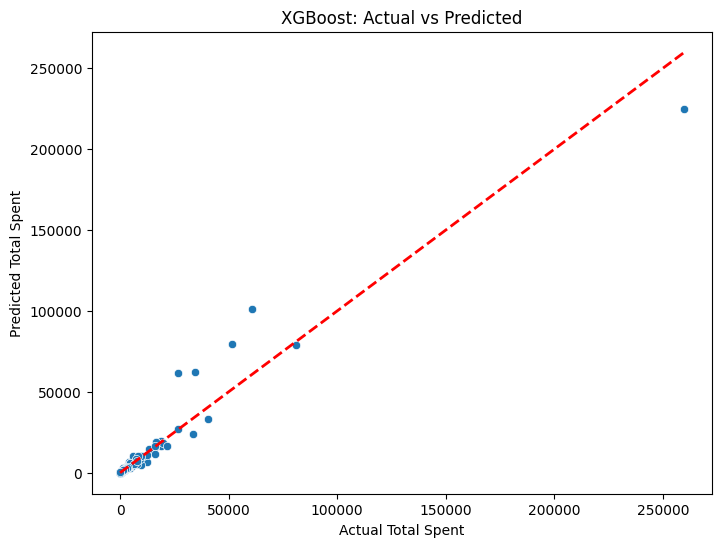

In [25]:
plt.figure(figsize=(8,6))

# Scatter: actual vs predicted
sns.scatterplot(x=y_test, y=y_pred)

# Perfect prediction line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', lw=2
)

plt.xlabel("Actual Total Spent")
plt.ylabel("Predicted Total Spent")
plt.title("XGBoost: Actual vs Predicted")
plt.show()